# Imports

In [1]:
import pandas as pd
import re

import warnings
warnings.filterwarnings('ignore')

import unicodedata
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
import sklearn.preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import wrangle as w
import explore as e
import modeling as m

# Acquire

* Data aquired from [Kaggle](https://www.kaggle.com/satpreetmakhija/netflix-movies-and-tv-shows-2021) on 2/04/2022
* Each observation represents on movie or film series 
* Because the distinction between a single movie an a multi-part series is not relevant to this study I will be referring to each as a movie for the duration of this study
* The original data set had 5967 rows and 13 columns

# Prepare

* The dataframe retained 5447 and 2 columns after preperarion
* Data was prepared using the fillowing steps:
    * Drop all columns other than 'description' and 'genre'
    * Lowercased text in both columns
    * Lowercased column names
    * Prepared text in 'description' for exploration using the following steps:
      * Removed all non-ascii and special characters form the text
      * Tokenized the words in the text
      * Lemmatized the words in the text
      * Removed stopwords
    * my goal for genre was to insure that each film only represented one genre after preperation
    * Prepared genre text using the following steps:
      * Removed text indicating if a film is a standalone movie or series
      * Created new column of curated list of genres       
      * The following genres were removed because they do not refer the films theam:
          * international
          * korean
          * teen
          * british
          * spanish-language 
          * independent
          * anime
          * kids
          * children & family    
          * classic & cult
          * classic
          * cult
      * The following genres were removed due to low representation
          * lgbtq
          * sci-fi & fantasy
          * sports
          * faith & spirituality
          * stand-up comedy & talk
          * mysteries    
      * Merged films with docuseries, documentary, or documentaries in it's genre list together into one genre documentaries
      * Merged together films with the following geres together under that genre alone
          * reality
          * music & musicals
          * crime
          * horror
      * Removed dramas from genre lists that contained three or more genes
      * Fused together the following genres to create new genres
          * romantic and comedies are now romantic comedies
          * dramas and comedies are now dramitic comedies
          * action & adventure and comedies are now action & adventure comedies
      * Removed drama from films that had other genres
      * Dropped rows that had more than one genre
      * Overwrote genre column using the genres from genre_list
      * Dropped nans from genre created by unpacking an empty string in the above step
      * Saved prepared data to 'preped_movies.csv'
      * Split data into train, validate, and test stradifying on genre

In [2]:
# acquire and prepare the data
train, validate, test = w.split_my_data(w.get_my_movie_data())

# Explore

## What is the distribution of genres?

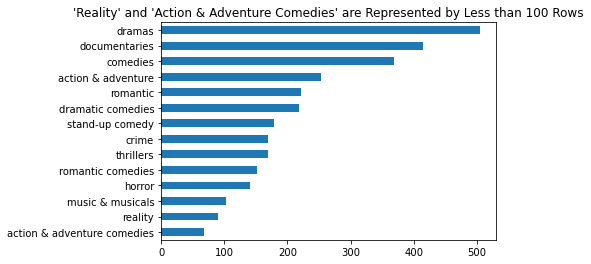

In [3]:
# get bar chart with distribution of genres
train.genre.value_counts().sort_values().plot(kind = 'barh', title = "'Reality' and 'Action & Adventure Comedies' are Represented by Less than 100 Rows")
plt.show()

* Future itterations of this project may drop 'Reality' and 'Action & Adventure Comedies' due to haveing less than 100 rows remaining in the train data 
* I will leave them as is for now

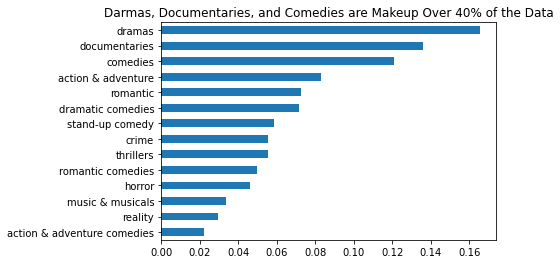

In [4]:
# get bar chart with normalized distribution of genres 
train.genre.value_counts(normalize=True).sort_values().plot(kind = 'barh', title = "Darmas, Documentaries, and Comedies are Makeup Over 40% of the Data")
plt.show()

* The top three genres represent over 40% of the data
* The bottom 11 Genres represent the remaining 60%

## What are the most common words used across all genres?

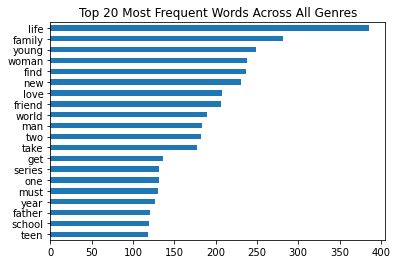

In [5]:
e.all_common(train)

## What are the most common words used across each genre?

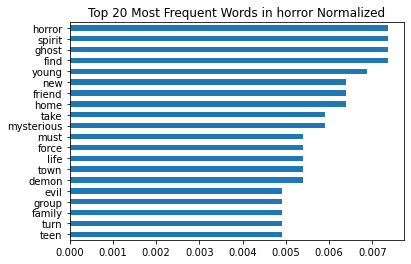

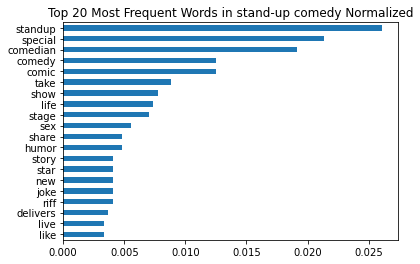

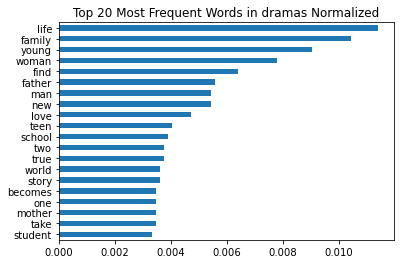

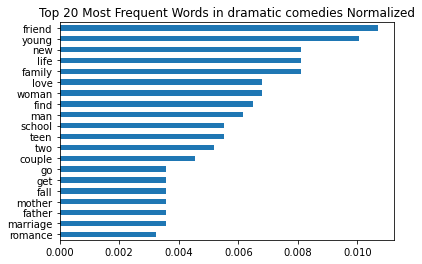

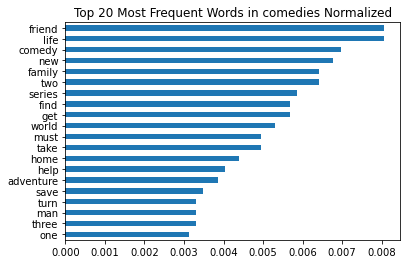

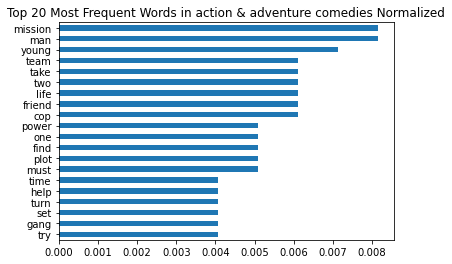

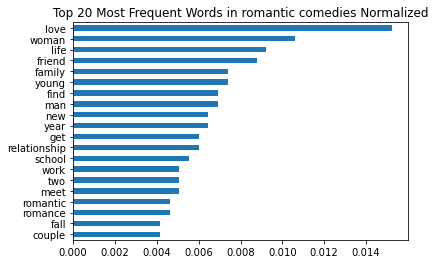

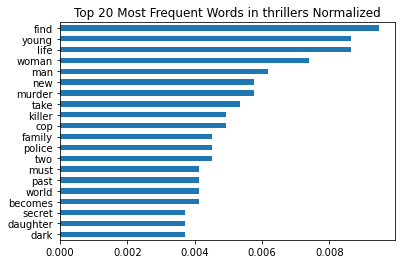

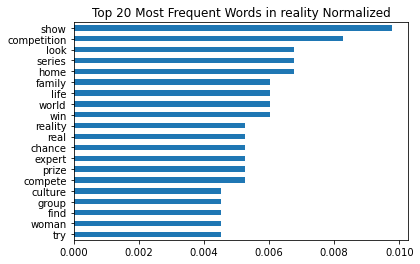

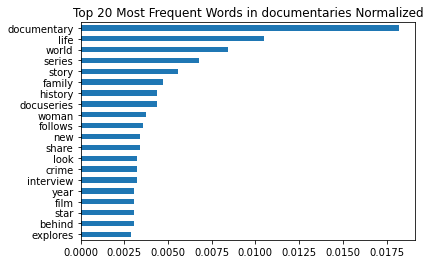

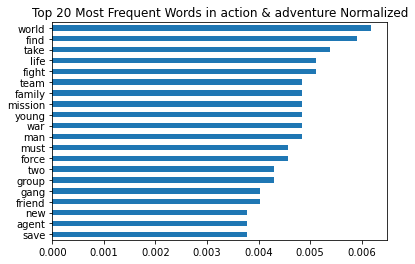

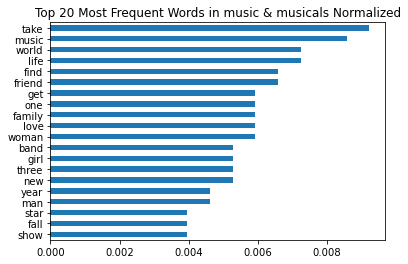

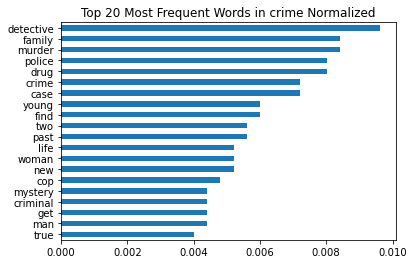

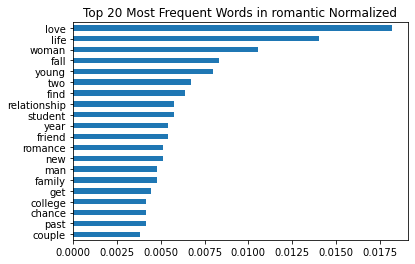

In [6]:
# get graph of most frequently occuring words in each genre
for genre in list(set(train.genre.to_list())):
    
    e.explore_word_count_norm(genre, train)

* Most of the highest frequencey words for each genre appear to represent less than 2% of the total words used for that genre
* Comedies is an exception the words standup and special each appear with a greater than 2%
* It is likely that there are some key words that will appear in most of the descriptions for a given genre, but not in others
* Such words will not nessesarily represent a large amout of the text but would surve to identify each genre none the less
* Perhaps looking at document frequency will shed more light on how to identify each genre

## Can I use presence or absence of 'signpost' words to predict genre
* I will define a 'signpost' word as a word that appears in a large number of documents in only a few catagories
* I will use the following method to test this hypothesis:  
  * create a list of all of the words in the train data
  * create a new dataframe df_spw using the train data and add columns showing a 1 if the description contains the word and a 0 if it dose not
  * drop words that appear in 6 or more genres 
  * build a simple regression model and evaluate preditive ability on train
  * if succesful make the same changes on validate data and evaluate the model's ability validata

In [9]:
def get_signpost(df, unique_words, file_name):
    
    # if input file name does not exist create new file
    if os.path.exists(f"{file_name}.csv") == False:
        
        # for each word in unique_words 
        for word in unique_words:

            # add a column with a value 1 if the description in that row has the word and a 0 if it does not
            df[f'{word}_'] = df.description.apply(lambda value: 1 if word in value else 0)

        # make a copy of df after columns are added
        new_df = df.copy()

        # group df by genre and get the max in each value
        df = df.groupby(by='genre').max().drop(columns=['description'])

        # for each word in unique_words 
        for word in unique_words:

            # if that word is in more than 6 catagories drop the column associated with that word in new df
            if df[f'{word}_'].value_counts()[1] >= 6:

                new_df.drop(columns=f'{word}_', inplace=True)

        # write new df to a file
        new_df.to_csv(f'{file_name}', index = False)

    # return read of new file name
    return pd.read_csv(f'{file_name}.csv')

In [10]:
# get a list of all the unique words in df
unique_words = set(' '.join(train.description).split(' '))
train_sign = get_signpost(train, unique_words, "train_signpost")
validate_sign = get_signpost(validate, unique_words, "validate_signpost")
test_sign = get_signpost(test, unique_words, "test_signpost")

FileNotFoundError: [Errno 2] No such file or directory: 'train_signposts.csv'

In [ ]:
# train_genre = train_spw.groupby(by='genre').max().drop(columns='description')

In [ ]:
 train_genre.shape

In [ ]:
 train_spw.shape

In [ ]:
# for word in unique_words:

#     if train_genre[f'{word}_'].value_counts()[1] >= 6:
        
#         train_spw.drop(columns=f'{word}_', inplace=True)

In [ ]:
train_spw.to_csv('signpost_words', index = False)

In [ ]:
sign = pd.read_csv("signpost_words")

In [ ]:
sign.genre.value_counts()

In [ ]:
sign.genre.value_counts().max()

## Baseline

In [ ]:
# get the percent of the data represented by the highest fequency genre to th nearist percent
f'{int(round(sign.genre.value_counts().max() / sign.genre.value_counts().sum(),2) * 100)}%'

In [ ]:
sign.columns

In [ ]:
sign.drop(columns='description', inplace=True)

In [ ]:
sign_X = sign.drop(columns='genre')
sign_y = sign.genre

In [ ]:
'genre' in sign_X.columns

In [ ]:
sign_y

In [ ]:
lr = LogisticRegression()

lr.fit(sign_X, sign_y)

print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(lr.score(sign_X, sign_y)))